In [3]:
%pylab inline
import glob
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp

import datetime as dt  
import io 
import os


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import random
import numpy.linalg as linalg

import geopandas as gpd

# import math
# from math import cos, log
import pylab as pl
import numpy as np
import patsy
import pandas as pd
# ADS kernel not working for this:
# import pandas_datareader.data as web
# from PIL import Image

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import seaborn as sns
from scipy.optimize import minimize
from scipy import stats
# from sklearn.model_selection import train_test_split
# from sklearn import linear_model
# from sklearn import neighbors, datasets
# from sklearn.ensemble import RandomForestClassifier


# from tabulate import tabulate
# import urllib.request as url
import zipfile 

puidata= os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False

import urllib.request as url

from geopandas.tools import sjoin
import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point
from fiona.crs import from_epsg

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIdata")
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile

In [9]:
# Download the Subway Station Shapefile
StationShapeFile = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"
urllib.urlretrieve(StationShapeFile, "SubwayStations.zip")
! mv SubwayStations.zip $PUIDATA
! unzip $PUIDATA/SubwayStations.zip -d $PUIDATA

Archive:  /nfshome/wz1405/PUIdata/SubwayStations.zip
  inflating: /nfshome/wz1405/PUIdata/geo_export_d8dedbe2-4d96-4e51-abfb-cfbc45cceab3.dbf  
  inflating: /nfshome/wz1405/PUIdata/geo_export_d8dedbe2-4d96-4e51-abfb-cfbc45cceab3.shp  
  inflating: /nfshome/wz1405/PUIdata/geo_export_d8dedbe2-4d96-4e51-abfb-cfbc45cceab3.shx  
  inflating: /nfshome/wz1405/PUIdata/geo_export_d8dedbe2-4d96-4e51-abfb-cfbc45cceab3.prj  


In [13]:
# Download the Subway Line Shapefile
LineShapeFile = "https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=Shapefile"
urllib.urlretrieve(LineShapeFile, "SubwayLines.zip")
! mv SubwayLines.zip $PUIDATA
! unzip $PUIDATA/SubwayLines.zip -d $PUIDATA

Archive:  /nfshome/wz1405/PUIdata/SubwayLines.zip
  inflating: /nfshome/wz1405/PUIdata/geo_export_227f7cac-91b4-41c5-b141-0b133c6ae55a.dbf  
  inflating: /nfshome/wz1405/PUIdata/geo_export_227f7cac-91b4-41c5-b141-0b133c6ae55a.shp  
  inflating: /nfshome/wz1405/PUIdata/geo_export_227f7cac-91b4-41c5-b141-0b133c6ae55a.shx  
  inflating: /nfshome/wz1405/PUIdata/geo_export_227f7cac-91b4-41c5-b141-0b133c6ae55a.prj  


In [18]:
# NYC Neighborhood Tabulation Areas Shapefile
# Ref: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
# https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile

In [57]:
NTAFile = "https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile"
urllib.urlretrieve(NTAFile, "NTA.zip")
! mv NTA.zip $PUIDATA
! unzip $PUIDATA/NTA.zip -d $PUIDATA

Archive:  /nfshome/wz1405/PUIdata/NTA.zip
  inflating: /nfshome/wz1405/PUIdata/geo_export_0da07b20-da55-4b56-acfc-afc669627083.dbf  
  inflating: /nfshome/wz1405/PUIdata/geo_export_0da07b20-da55-4b56-acfc-afc669627083.shp  
  inflating: /nfshome/wz1405/PUIdata/geo_export_0da07b20-da55-4b56-acfc-afc669627083.shx  
  inflating: /nfshome/wz1405/PUIdata/geo_export_0da07b20-da55-4b56-acfc-afc669627083.prj  


In [17]:
# NYC population by neighborhood tabulation areas
# Ref: https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/data
# https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD

In [53]:
# Download the Population Tabulation Areas File
PopFile = "https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD"
urllib.urlretrieve(PopFile, "PopNTA.csv")
! mv PopNTA.csv $PUIDATA

In [4]:
# Read Subway Station shapefile
Stationshp = gpd.read_file(os.getenv("PUIDATA") + "/geo_export_d8dedbe2-4d96-4e51-abfb-cfbc45cceab3.shp")

In [5]:
Stationshp.shape

(473, 6)

In [6]:
Stationshp.head()

,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-73.99106999861966 40.73005400028978)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (-74.00019299927328 40.71880300107709)
2,1-2,50th St,"1-all times, 2-nights",3.0,http://web.mta.info/nyct/service/,POINT (-73.98384899986625 40.76172799961419)
3,2-3-4,Bergen St,"4-nights, 3-all other times, 2-all times",4.0,http://web.mta.info/nyct/service/,POINT (-73.97499915116808 40.68086213682956)
4,3-4,Pennsylvania Ave,"4-nights, 3-all other times",5.0,http://web.mta.info/nyct/service/,POINT (-73.89488591154061 40.66471445143568)


In [ ]:
https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=Shapefile

In [7]:
# Read Subway Line shapefile
Lineshp = gpd.read_file(os.getenv("PUIDATA") + "/geo_export_227f7cac-91b4-41c5-b141-0b133c6ae55a.shp")

In [8]:
Lineshp.shape

(742, 7)

In [9]:
Lineshp.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,LINESTRING (-73.99487524803018 40.680203546062...
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,LINESTRING (-73.97957543205142 40.659930695530...
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,LINESTRING (-73.97585637503069 40.575974505394...
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,LINESTRING (-73.92414355434533 40.752290926571...
4,2000296.0,M,757.0,B,2385.698536,http://web.mta.info/nyct/service/,LINESTRING (-73.91344685471373 40.756171576368...


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


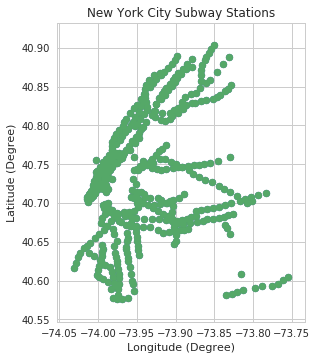

In [255]:
ax = Stationshp.plot()

pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('New York City Subway Stations')

Stationshp.plot(ax = ax)

pylab.show()

# Caption: 
    This is a visualization for the spatial distribution of New York City Subway stations.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


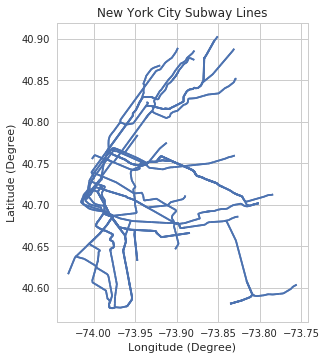

In [256]:
ax = Lineshp.plot()

pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('New York City Subway Lines')

Lineshp.plot(ax = ax)
pylab.show()

# Caption: 
    This is a plot of the subway lines of the New York City. My observation is that the Staten Island Railroad, often regarded as a subway line as it utilizes a fleet of subway cars, is not shown on the map. It is probably because that it is under another division instead of the division of subway. Thus, the dataset does not contain the Staten Island Neighborhood Tabulation Areas, which are roughly 20 of them, and partially explained the drop in the shape of the dataset after merging with the NTA dataset. 

In [248]:
# Sjoin both to produce MTA, may not be necessary for the complete system map
# MTA = gpd.sjoin(Lineshp, Stationshp, how="left")
# Lineshp.crs
# Stationshp.crs
# MTA.shape

    Reference: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/ntas.pdf 
    Neighborhood Tabulation Areas or NTAs, are aggregations of census tracts that are subsets of New York City's 55 Public Use Microdata Areas (PUMAs). Primarily due to these constraints, NTA boundaries and their associated names may not definitively represent neighborhoods.

In [14]:
# Read Subway Line shapefile
NTAshp = gpd.read_file(os.getenv("PUIDATA") + "/geo_export_0da07b20-da55-4b56-acfc-afc669627083.shp")

In [15]:
NTAshp.shape

(195, 8)

In [16]:
NTAshp.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,POLYGON ((-73.97604935657381 40.63127590564677...
1,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904861,POLYGON ((-73.80379022888246 40.77561011179248...
2,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712318,"POLYGON ((-73.86109724335759 40.7636644770869,..."
3,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335574,POLYGON ((-73.75725671509139 40.71813860166257...
4,1.0,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685413,POLYGON ((-73.94607828674226 40.82126321606191...


In [19]:
PopNTA = pd.read_csv(os.getenv("PUIDATA") + "/PopNTA.csv")

In [20]:
PopNTA.shape

(390, 6)

In [21]:
PopNTA.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,35422
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,55329
3,Bronx,2000,5,BX06,Belmont,25967
4,Bronx,2000,5,BX07,Bronxdale,34309


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


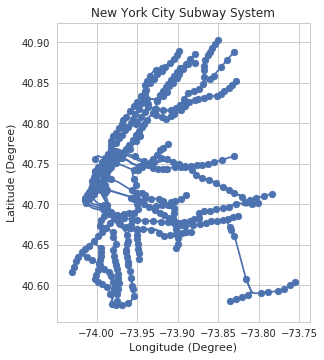

In [257]:
ax = Lineshp.plot()
Stationshp.plot(ax=ax)

pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('New York City Subway System')
pylab.show()

# Caption: 
    This is a visualization for the spatial distribution of New York City Subway services overlayed.

In [22]:
# Merge the NTA files

In [23]:
PopNTAMerge = NTAshp.merge(PopNTA, left_on='ntacode', right_on='NTA Code')

In [24]:
PopNTAMerge.shape

(390, 14)

In [25]:
PopNTAMerge.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,POLYGON ((-73.97604935657381 40.63127590564677...,Brooklyn,2000,47,BK88,Borough Park,101055
1,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,POLYGON ((-73.97604935657381 40.63127590564677...,Brooklyn,2010,47,BK88,Borough Park,106357
2,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904861,POLYGON ((-73.80379022888246 40.77561011179248...,Queens,2000,81,QN51,Murray Hill,53009
3,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904861,POLYGON ((-73.80379022888246 40.77561011179248...,Queens,2010,81,QN51,Murray Hill,51739
4,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712318,"POLYGON ((-73.86109724335759 40.7636644770869,...",Queens,2000,81,QN27,East Elmhurst,21183


In [26]:
PopNTAMerge2000 = PopNTAMerge[PopNTAMerge['Year'] == 2000]
PopNTAMerge2010 = PopNTAMerge[PopNTAMerge['Year'] == 2010]

In [27]:
PopNTAMerge2000.shape

(195, 14)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


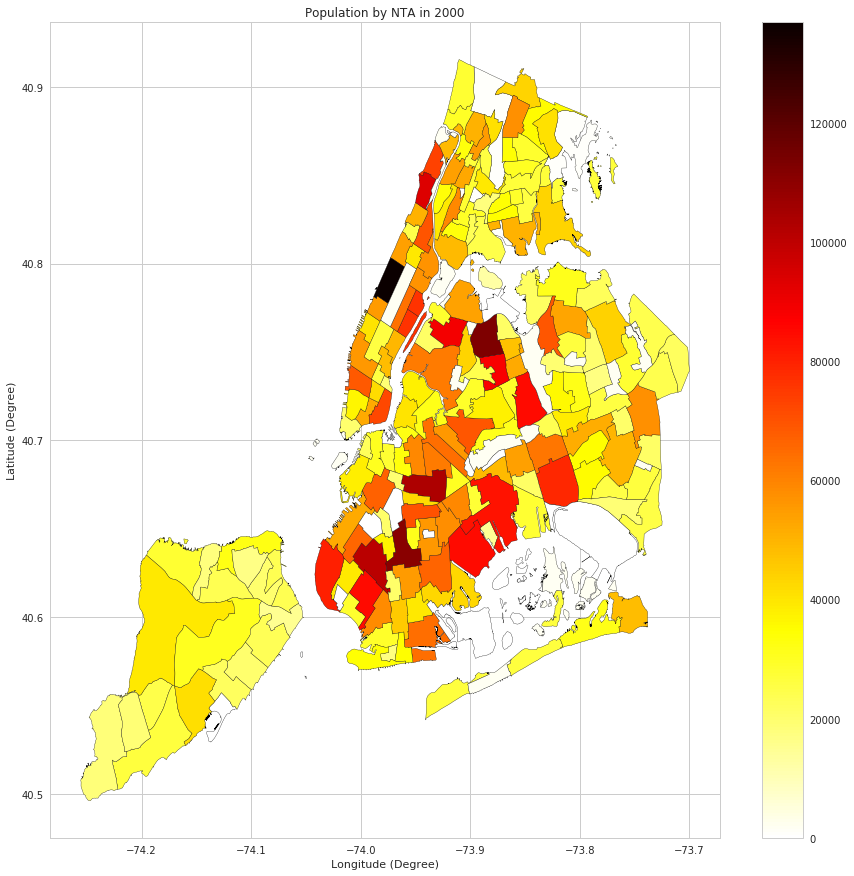

In [258]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
PopNTAMerge2000.plot(column='Population', edgecolor='black', cmap='hot_r', ax=ax, legend=True)
pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('Population by NTA in 2000')

pylab.savefig('PopNTAMerge2000.png')
pylab.show()

# Caption: 
    This is a visualization for the Population by NTA in 2000.

In [29]:
PopNTAMerge2010.shape

(195, 14)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


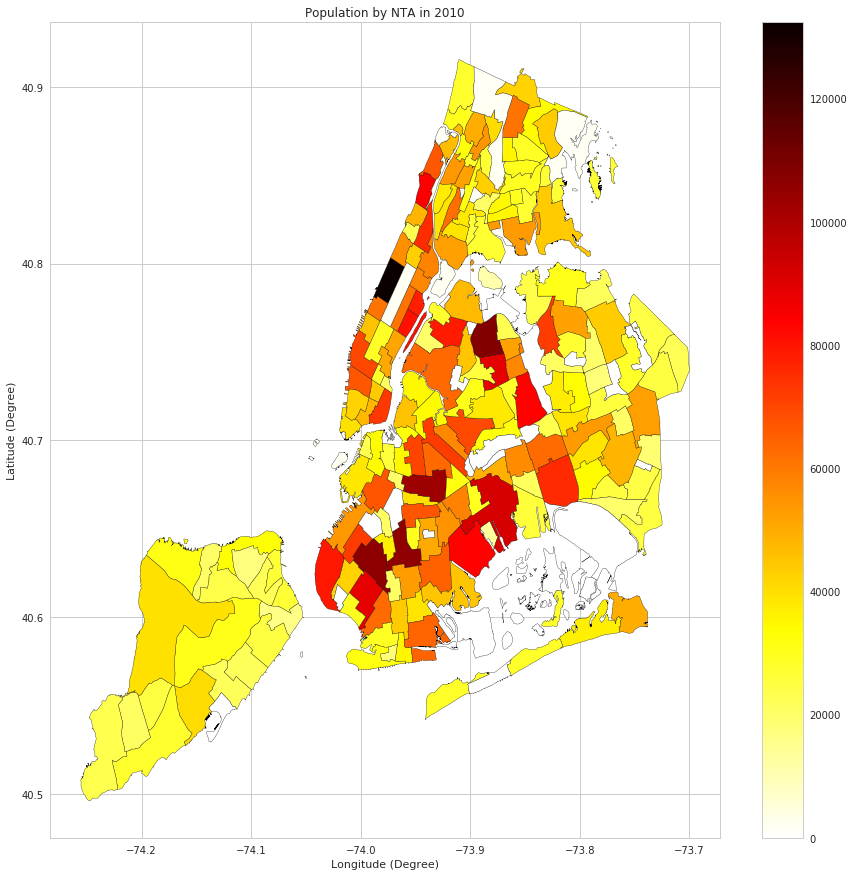

In [259]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('Population by NTA in 2010')

PopNTAMerge2010.plot(column='Population', edgecolor='black', cmap='hot_r', ax=ax, legend=True)

pylab.savefig('PopNTAMerge2010.png')

pylab.show()

# Caption: 
    This is a visualization for the Population by NTA in 2010.

In [31]:
# PopNTAMerge2000.to_csv(os.getenv("PUIDATA") + '/PopNTAMerge2000.csv')
# PopNTAMerge2010.to_csv(os.getenv("PUIDATA") + '/PopNTAMerge2010.csv')

In [32]:
# Calculate Population Density by dividing the population by shape_area
PopNTAMerge2000['PopDensity'] = PopNTAMerge2000['Population'] / PopNTAMerge2000['shape_area']
PopNTAMerge2010['PopDensity'] = PopNTAMerge2010['Population'] / PopNTAMerge2010['shape_area']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


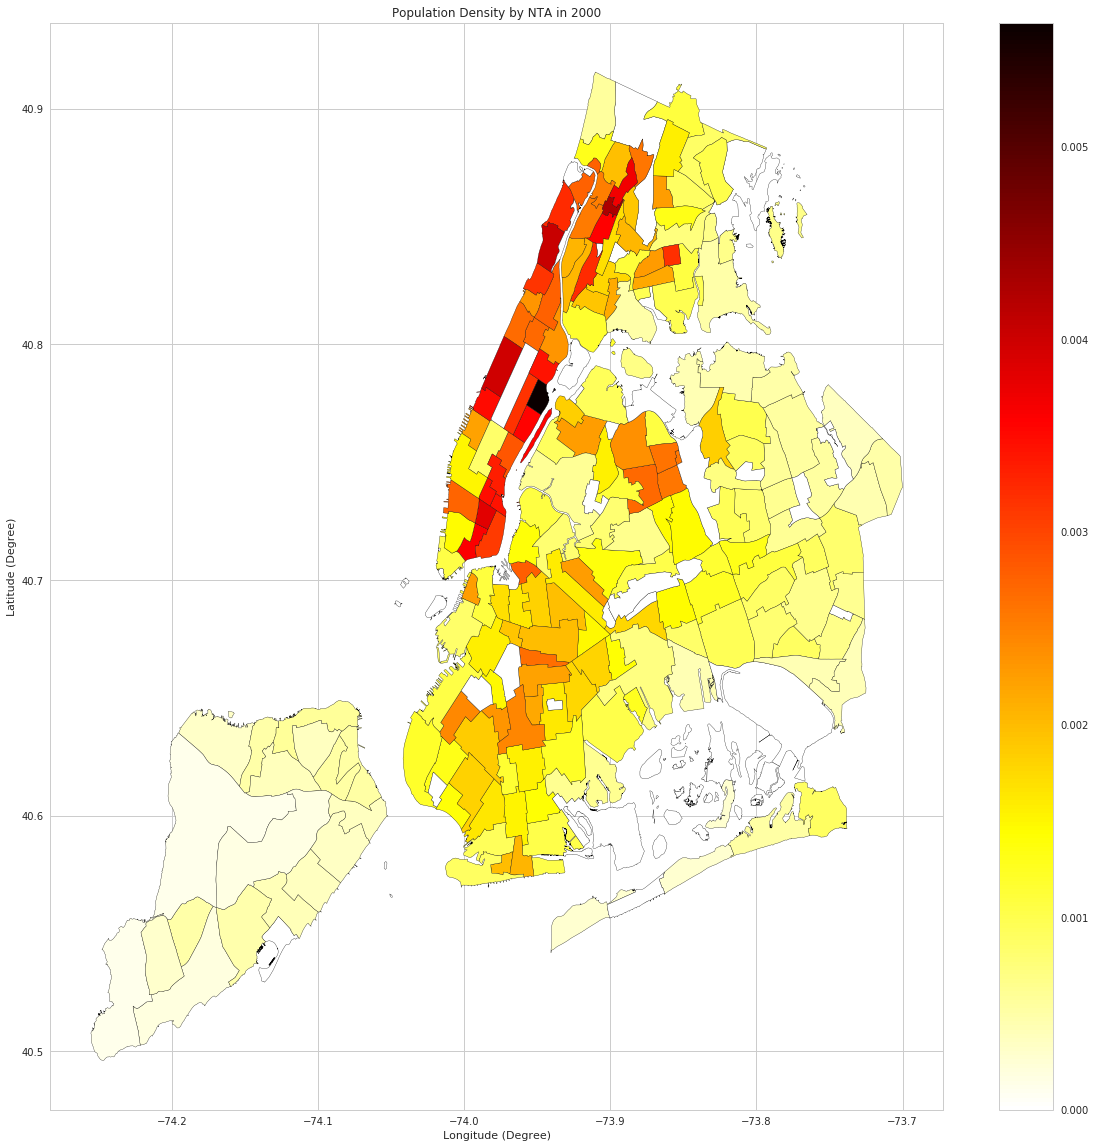

In [260]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('Population Density by NTA in 2000')
PopNTAMerge2000.plot(column='PopDensity', edgecolor='black', cmap='hot_r', ax=ax, legend=True)

pylab.show()

# Caption: 
    This is a visualization for the Population Density by NTA in 2000.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


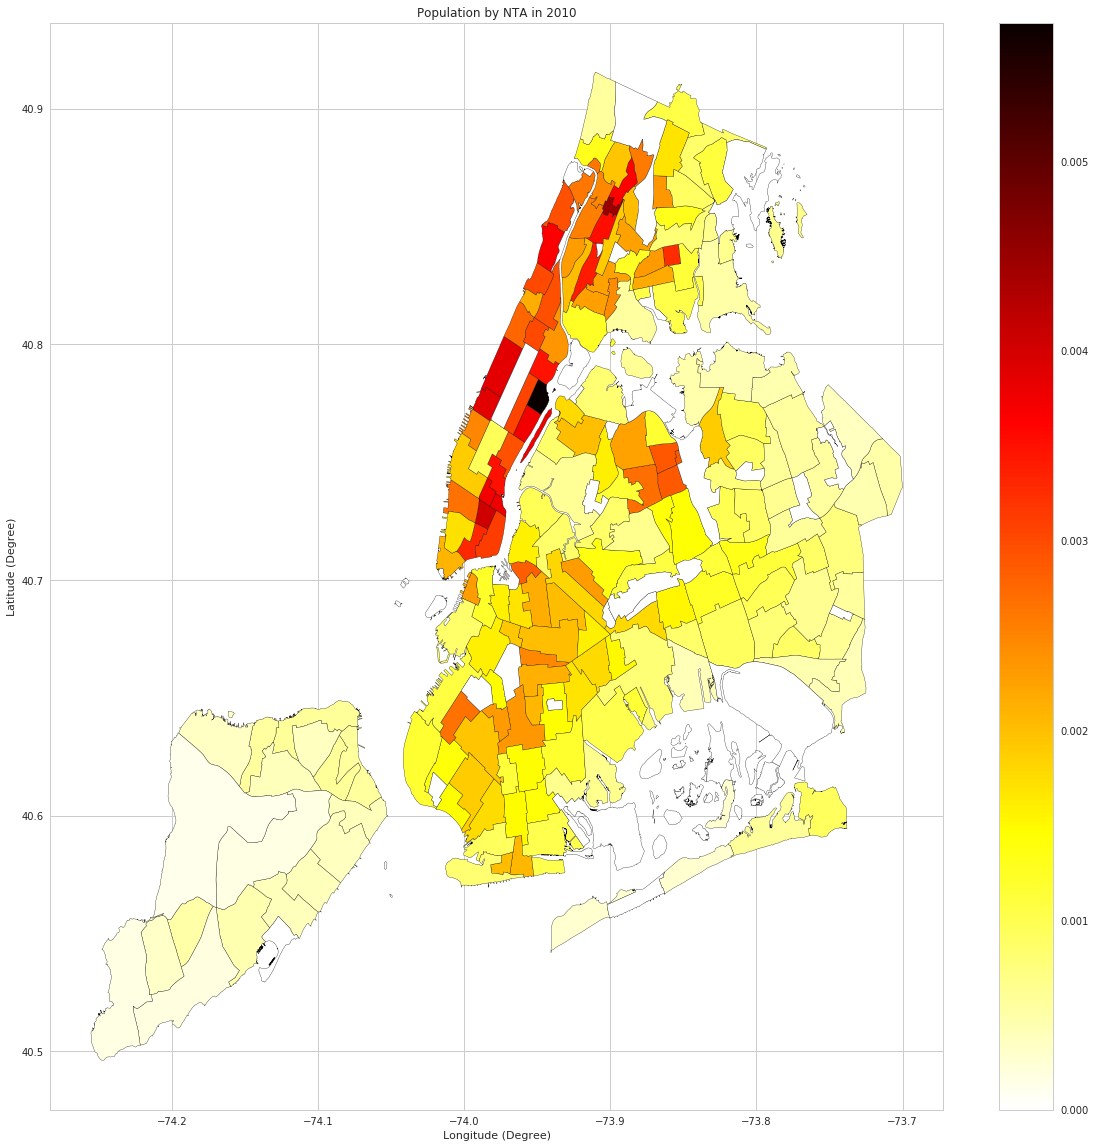

In [261]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('Population by NTA in 2010')
PopNTAMerge2010.plot(column='PopDensity', edgecolor='black', cmap='hot_r', ax=ax, legend=True)

pylab.show()

# Caption: 
    This is a visualization for the Population Density by NTA in 2010.

In [35]:
PopNTAMerge2010.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,PopDensity
1,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,POLYGON ((-73.97604935657381 40.63127590564677...,Brooklyn,2010,47,BK88,Borough Park,106357,0.001969
3,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904861,POLYGON ((-73.80379022888246 40.77561011179248...,Queens,2010,81,QN51,Murray Hill,51739,0.000986
5,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712318,"POLYGON ((-73.86109724335759 40.7636644770869,...",Queens,2010,81,QN27,East Elmhurst,23150,0.001174
7,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335574,POLYGON ((-73.75725671509139 40.71813860166257...,Queens,2010,81,QN07,Hollis,20269,0.000886
9,1.0,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685413,POLYGON ((-73.94607828674226 40.82126321606191...,Manhattan,2010,61,MN06,Manhattanville,22950,0.002156


In [36]:
# To find out the Population Change
# Separate PopNTA file out by 2000 and 2010 and merge them back for calculation

In [41]:
PopNTA2000 =  PopNTA[PopNTA['Year'] == 2000]
PopNTA2010 =  PopNTA[PopNTA['Year'] == 2010]

In [42]:
PopNTA2010.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
195,Bronx,2010,5,BX01,Claremont-Bathgate,31078
196,Bronx,2010,5,BX03,Eastchester-Edenwald-Baychester,34517
197,Bronx,2010,5,BX05,Bedford Park-Fordham North,54415
198,Bronx,2010,5,BX06,Belmont,27378
199,Bronx,2010,5,BX07,Bronxdale,35538


In [43]:
PopNTAChangeMerge = PopNTA2000.merge(PopNTA2010, left_on='NTA Code', right_on='NTA Code')

In [44]:
PopNTAChangeMerge.head()

,Borough_x,Year_x,FIPS County Code_x,NTA Code,NTA Name_x,Population_x,Borough_y,Year_y,FIPS County Code_y,NTA Name_y,Population_y
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149,Bronx,2010,5,Claremont-Bathgate,31078
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,35422,Bronx,2010,5,Eastchester-Edenwald-Baychester,34517
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,55329,Bronx,2010,5,Bedford Park-Fordham North,54415
3,Bronx,2000,5,BX06,Belmont,25967,Bronx,2010,5,Belmont,27378
4,Bronx,2000,5,BX07,Bronxdale,34309,Bronx,2010,5,Bronxdale,35538


In [69]:
PopNTAChangeMerge['PopulationChange'] = PopNTAChangeMerge['Population_y'] - PopNTAChangeMerge['Population_x']
PopNTAChangeMerge['PopulationPercentChange'] = ((PopNTAChangeMerge['Population_y'] - PopNTAChangeMerge['Population_x']) * 100)/ PopNTAChangeMerge['Population_x']


In [70]:
PopNTAChangeMerge.head()

,Borough_x,Year_x,FIPS County Code_x,NTA Code,NTA Name_x,Population_x,Borough_y,Year_y,FIPS County Code_y,NTA Name_y,Population_y,PopulationChange,PopulationPercentChange
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149,Bronx,2010,5,Claremont-Bathgate,31078,2929,10.405343
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,35422,Bronx,2010,5,Eastchester-Edenwald-Baychester,34517,-905,-2.554909
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,55329,Bronx,2010,5,Bedford Park-Fordham North,54415,-914,-1.651937
3,Bronx,2000,5,BX06,Belmont,25967,Bronx,2010,5,Belmont,27378,1411,5.433820
4,Bronx,2000,5,BX07,Bronxdale,34309,Bronx,2010,5,Bronxdale,35538,1229,3.582150


In [71]:
PopNTAChangeMergeSHP = NTAshp.merge(PopNTAChangeMerge, left_on='ntacode', right_on='NTA Code')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


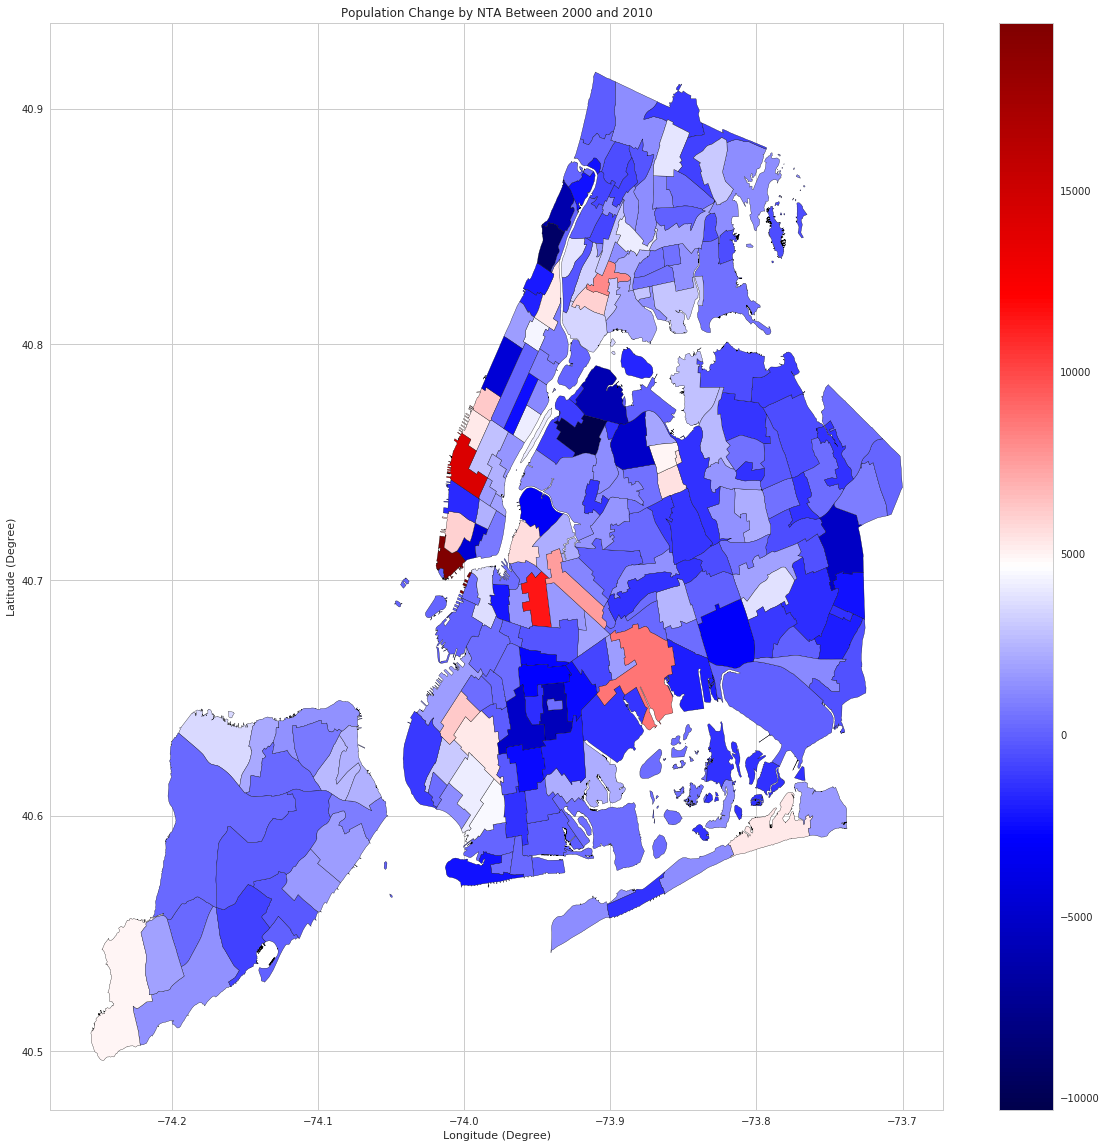

In [262]:
# Population Change Between 2000 and 2010
# Cmap Ref: https://matplotlib.org/tutorials/colors/colormaps.html
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

PopNTAChangeMergeSHP.plot(column='PopulationChange', edgecolor='black', cmap='seismic', ax=ax, legend=True)
pylab.xlabel('Longitude (Degree)')
pylab.ylabel('Latitude (Degree)')
pylab.title('Population Change by NTA Between 2000 and 2010')

pylab.savefig('PopNTAChange2000.png')

pylab.show()

# Caption:
    This is a visualization of the Population Change by NTA Between 2000 and 2010.

In [74]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)
# PopNTAChangeMergeSHP.plot(column='PopulationPercentChange', edgecolor='black', cmap='seismic', ax=ax, legend=True)

In [75]:
Lineshp.shape

(742, 7)

In [76]:
PopNTAChangeMergeSHP.shape

(195, 21)

In [77]:
LineshpSJoin = gpd.sjoin(Lineshp, PopNTAChangeMergeSHP)
LineshpSJoin.shape

(1212, 28)

In [53]:
LineshpSJoin.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry,index_right,boro_code,boro_name,...,FIPS County Code_x,NTA Code,NTA Name_x,Population_x,Borough_y,Year_y,FIPS County Code_y,NTA Name_y,Population_y,PopulationChange
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,LINESTRING (-73.99487524803018 40.680203546062...,147,3.0,Brooklyn,...,47,BK33,Carroll Gardens-Columbia Street-Red Hook,38327,Brooklyn,2010,47,Carroll Gardens-Columbia Street-Red Hook,38353,26
512,2000394.0,G,1262.0,G,2641.143599,http://web.mta.info/nyct/service/,LINESTRING (-73.99486645268799 40.680213117237...,147,3.0,Brooklyn,...,47,BK33,Carroll Gardens-Columbia Street-Red Hook,38327,Brooklyn,2010,47,Carroll Gardens-Columbia Street-Red Hook,38353,26
713,2000393.0,F,1468.0,B,2427.979321,http://web.mta.info/nyct/service/,LINESTRING (-73.99504799936742 40.680302666934...,147,3.0,Brooklyn,...,47,BK33,Carroll Gardens-Columbia Street-Red Hook,38327,Brooklyn,2010,47,Carroll Gardens-Columbia Street-Red Hook,38353,26
714,2000394.0,F,1469.0,B,2724.937971,http://web.mta.info/nyct/service/,LINESTRING (-73.99595900048809 40.673579667071...,147,3.0,Brooklyn,...,47,BK33,Carroll Gardens-Columbia Street-Red Hook,38327,Brooklyn,2010,47,Carroll Gardens-Columbia Street-Red Hook,38353,26
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,LINESTRING (-73.99487524803018 40.680203546062...,123,3.0,Brooklyn,...,47,BK38,DUMBO-Vinegar Hill-Downtown Brklyn-Boerum Hill,30847,Brooklyn,2010,47,DUMBO-Vinegar Hill-Downtown Brklyn-Boerum Hill,34495,3648


In [54]:
LineshpSJoin.describe()

,id,objectid,shape_len,index_right,boro_code,shape_area,shape_leng,Year_x,FIPS County Code_x,Population_x,Year_y,FIPS County Code_y,Population_y,PopulationChange
count,1.212000e+03,1212.000000,1212.000000,1212.000000,1212.000000,1.212000e+03,1212.000000,1212.0,1212.000000,1212.000000,1212.0,1212.000000,1212.000000,1212.000000
mean,1.955705e+06,1124.453795,2515.231725,105.535479,2.499175,3.900538e+07,43753.546691,2000.0,52.123762,48675.043729,2010.0,52.123762,50159.744224,1484.700495
std,2.953285e+05,221.792440,1762.801272,55.669423,1.110344,3.886278e+07,57918.251954,0.0,22.729542,25598.694421,0.0,22.729542,24954.788625,4457.838841
min,0.000000e+00,753.000000,175.375553,0.000000,1.000000,5.581768e+06,11988.418968,2000.0,5.000000,0.000000,2010.0,5.000000,0.000000,-10329.000000
25%,2.000119e+06,935.750000,1741.548438,51.000000,1.000000,1.938694e+07,24732.345975,2000.0,47.000000,29257.000000,2010.0,47.000000,29938.000000,-799.000000
50%,2.000264e+06,1115.500000,2198.113604,110.000000,3.000000,2.847709e+07,29393.935726,2000.0,47.000000,47156.000000,2010.0,47.000000,46746.000000,1045.000000
75%,2.000389e+06,1314.000000,2714.385809,153.000000,3.000000,4.189853e+07,37708.334292,2000.0,61.000000,63897.000000,2010.0,61.000000,66880.000000,3383.000000
max,2.000542e+06,1873.000000,19403.240518,193.000000,4.000000,3.116458e+08,490420.509920,2000.0,81.000000,136954.000000,2010.0,81.000000,132378.000000,19611.000000


In [56]:
StationshpSJoin = gpd.sjoin(Stationshp, PopNTAChangeMergeSHP)
StationshpSJoin.shape

(473, 26)

In [63]:
StationshpSJoin.head()

,line,name,notes,objectid,url,geometry,index_right,boro_code,boro_name,county_fip,...,FIPS County Code_x,NTA Code,NTA Name_x,Population_x,Borough_y,Year_y,FIPS County Code_y,NTA Name_y,Population_y,PopulationChange
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-73.99106999861966 40.73005400028978),178,1.0,Manhattan,061,...,61,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603
83,B-D-F-M,W 4th St - Washington Sq (Lower),"B,M-weekdays and evenings, D,F-all times",84.0,http://web.mta.info/nyct/service/,POINT (-74.00030814755975 40.73225449336788),178,1.0,Manhattan,061,...,61,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603
194,1-2,Christopher St - Sheridan Sq,"1-all times, 2-nights",195.0,http://web.mta.info/nyct/service/,POINT (-74.00290599855235 40.73342200104225),178,1.0,Manhattan,061,...,61,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603
205,A-C-E,W 4th St - Washington Sq (Upper),"A,E-all times, C-all times exc nights",206.0,http://web.mta.info/nyct/service/,POINT (-74.00049500225435 40.73233799774325),178,1.0,Manhattan,061,...,61,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603
383,L,Union Sq - 14th St,L-all times,384.0,http://web.mta.info/nyct/service/,POINT (-73.99066976901818 40.73476331217923),178,1.0,Manhattan,061,...,61,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603


In [55]:
# LineshpSJoin.to_csv(os.getenv("PUIDATA") + '/LineshpSJoin.csv')

In [121]:
# When visualizing the population change against the subway services did on the ArcMap. The Attribute Table joined
# only showed up for those with both the subway station & line services and population data
# if there isn't subway service in the Tabulation Areas, the ArcMap will show a blank Tabulation Area.

In [106]:
StationshpSJoin.columns.values

array(['line', 'name', 'notes', 'objectid', 'url', 'geometry',
       'index_right', 'boro_code', 'boro_name', 'county_fip', 'ntacode',
       'ntaname', 'shape_area', 'shape_leng', 'Borough_x', 'Year_x',
       'FIPS County Code_x', 'NTA Code', 'NTA Name_x', 'Population_x',
       'Borough_y', 'Year_y', 'FIPS County Code_y', 'NTA Name_y',
       'Population_y', 'PopulationChange', 'PopDensity'], dtype=object)

In [109]:
StationshpSJoinDataAna.head()

,line,name,objectid,boro_code,ntacode,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
0,4-6-6 Express,Astor Pl,1.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
83,B-D-F-M,W 4th St - Washington Sq (Lower),84.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
194,1-2,Christopher St - Sheridan Sq,195.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
205,A-C-E,W 4th St - Washington Sq (Upper),206.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
383,L,Union Sq - 14th St,384.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675


In [98]:
PopNTAMerge2010.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,PopDensity
1,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,POLYGON ((-73.97604935657381 40.63127590564677...,Brooklyn,2010,47,BK88,Borough Park,106357,0.001969
3,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904861,POLYGON ((-73.80379022888246 40.77561011179248...,Queens,2010,81,QN51,Murray Hill,51739,0.000986
5,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712318,"POLYGON ((-73.86109724335759 40.7636644770869,...",Queens,2010,81,QN27,East Elmhurst,23150,0.001174
7,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335574,POLYGON ((-73.75725671509139 40.71813860166257...,Queens,2010,81,QN07,Hollis,20269,0.000886
9,1.0,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685413,POLYGON ((-73.94607828674226 40.82126321606191...,Manhattan,2010,61,MN06,Manhattanville,22950,0.002156


In [99]:
PopNTAMerge2010.shape

(195, 15)

In [100]:
# Sort Pop Density

In [103]:
StationshpSJoin.shape

(473, 26)

In [142]:
StationshpSJoin.columns.values

array(['line', 'name', 'notes', 'objectid', 'url', 'geometry',
       'index_right', 'boro_code', 'boro_name', 'county_fip', 'ntacode',
       'ntaname', 'shape_area', 'shape_leng', 'Borough_x', 'Year_x',
       'FIPS County Code_x', 'NTA Code', 'NTA Name_x', 'Population_x',
       'Borough_y', 'Year_y', 'FIPS County Code_y', 'NTA Name_y',
       'Population_y', 'PopulationChange', 'PopDensity'], dtype=object)

In [143]:
StationshpSJoin['PopDensity'] = StationshpSJoin['Population_y'] / StationshpSJoin['shape_area']
StationshpSJoin.head()

,line,name,notes,objectid,url,geometry,index_right,boro_code,boro_name,county_fip,...,NTA Code,NTA Name_x,Population_x,Borough_y,Year_y,FIPS County Code_y,NTA Name_y,Population_y,PopulationChange,PopDensity
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-73.99106999861966 40.73005400028978),178,1.0,Manhattan,061,...,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603,0.002675
83,B-D-F-M,W 4th St - Washington Sq (Lower),"B,M-weekdays and evenings, D,F-all times",84.0,http://web.mta.info/nyct/service/,POINT (-74.00030814755975 40.73225449336788),178,1.0,Manhattan,061,...,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603,0.002675
194,1-2,Christopher St - Sheridan Sq,"1-all times, 2-nights",195.0,http://web.mta.info/nyct/service/,POINT (-74.00290599855235 40.73342200104225),178,1.0,Manhattan,061,...,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603,0.002675
205,A-C-E,W 4th St - Washington Sq (Upper),"A,E-all times, C-all times exc nights",206.0,http://web.mta.info/nyct/service/,POINT (-74.00049500225435 40.73233799774325),178,1.0,Manhattan,061,...,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603,0.002675
383,L,Union Sq - 14th St,L-all times,384.0,http://web.mta.info/nyct/service/,POINT (-73.99066976901818 40.73476331217923),178,1.0,Manhattan,061,...,MN23,West Village,68483,Manhattan,2010,61,West Village,66880,-1603,0.002675


In [162]:
StationshpSJoinDataAna = StationshpSJoin[['line', 'name', 'objectid', 'boro_code', 'ntacode', 'index_right',
                                         'Year_x', 'Population_x', 'Year_y', 'Population_y', 'PopulationChange', 'PopDensity']]

In [163]:
StationshpSJoinDataAna.head()

,line,name,objectid,boro_code,ntacode,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
0,4-6-6 Express,Astor Pl,1.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
83,B-D-F-M,W 4th St - Washington Sq (Lower),84.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
194,1-2,Christopher St - Sheridan Sq,195.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
205,A-C-E,W 4th St - Washington Sq (Upper),206.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675
383,L,Union Sq - 14th St,384.0,1.0,MN23,178,2000,68483,2010,66880,-1603,0.002675


In [164]:
StationshpSJoinDataAna1 = StationshpSJoinDataAna.groupby('ntacode').count()['line']

In [167]:
StationshpSJoinDataAna1 = pd.DataFrame(StationshpSJoinDataAna1)

In [171]:
StationshpSJoinDataAna1 = StationshpSJoinDataAna1.reset_index()

In [173]:
StationshpSJoinDataAna2 = StationshpSJoinDataAna1.merge(StationshpSJoinDataAna, left_on='ntacode', right_on='ntacode')
StationshpSJoinDataAna2.head(10)

,ntacode,line_x,line_y,name,objectid,boro_code,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
0,BK09,3,4-5,Borough Hall,123.0,3.0,63,2000,22548,2010,22887,339,0.002292
1,BK09,3,N-R,Court St,378.0,3.0,63,2000,22548,2010,22887,339,0.002292
2,BK09,3,2-3,Clark St,446.0,3.0,63,2000,22548,2010,22887,339,0.002292
3,BK17,2,B-Q,Sheepshead Bay,328.0,3.0,16,2000,64596,2010,64518,-78,0.001019
4,BK17,2,Q,Neck Rd,345.0,3.0,16,2000,64596,2010,64518,-78,0.001019
5,BK19,2,Q,Ocean Pkwy,100.0,3.0,118,2000,35244,2010,35547,303,0.002069
6,BK19,2,B-Q,Brighton Beach,327.0,3.0,118,2000,35244,2010,35547,303,0.002069
7,BK21,1,F,Neptune Ave,333.0,3.0,119,2000,34267,2010,31965,-2302,0.000824
8,BK23,2,F-Q,W 8th St - NY Aquarium,198.0,3.0,58,2000,17370,2010,17750,380,0.002031
9,BK23,2,D-F-N-Q,Coney Island - Stillwell Av,469.0,3.0,58,2000,17370,2010,17750,380,0.002031


In [174]:
StationshpSJoinDataAna2 = StationshpSJoinDataAna2.rename(columns={'line_x':'Number of Stations'})

In [175]:
StationshpSJoinDataAna2.head()

,ntacode,Number of Stations,line_y,name,objectid,boro_code,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
0,BK09,3,4-5,Borough Hall,123.0,3.0,63,2000,22548,2010,22887,339,0.002292
1,BK09,3,N-R,Court St,378.0,3.0,63,2000,22548,2010,22887,339,0.002292
2,BK09,3,2-3,Clark St,446.0,3.0,63,2000,22548,2010,22887,339,0.002292
3,BK17,2,B-Q,Sheepshead Bay,328.0,3.0,16,2000,64596,2010,64518,-78,0.001019
4,BK17,2,Q,Neck Rd,345.0,3.0,16,2000,64596,2010,64518,-78,0.001019


In [176]:
StationshpSJoinDataAna2.shape

(473, 13)

In [183]:
# Ref: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html
StationshpSJoinDataAna3 = StationshpSJoinDataAna2.drop_duplicates(subset='ntacode')

In [184]:
StationshpSJoinDataAna3.head()

,ntacode,Number of Stations,line_y,name,objectid,boro_code,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
0,BK09,3,4-5,Borough Hall,123.0,3.0,63,2000,22548,2010,22887,339,0.002292
3,BK17,2,B-Q,Sheepshead Bay,328.0,3.0,16,2000,64596,2010,64518,-78,0.001019
5,BK19,2,Q,Ocean Pkwy,100.0,3.0,118,2000,35244,2010,35547,303,0.002069
7,BK21,1,F,Neptune Ave,333.0,3.0,119,2000,34267,2010,31965,-2302,0.000824
8,BK23,2,F-Q,W 8th St - NY Aquarium,198.0,3.0,58,2000,17370,2010,17750,380,0.002031


In [185]:
StationshpSJoinDataAna3.shape

(125, 13)

In [192]:
StationshpSJoinDataAna3.dtypes

ntacode                object
Number of Stations      int64
line_y                 object
name                   object
objectid              float64
boro_code             float64
index_right             int64
Year_x                  int64
Population_x            int64
Year_y                  int64
Population_y            int64
PopulationChange        int64
PopDensity            float64
dtype: object

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


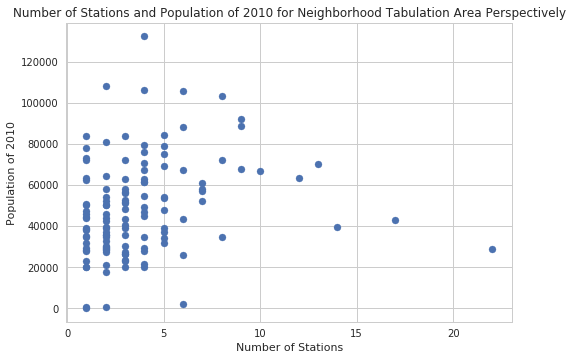

In [194]:
x1 = StationshpSJoinDataAna3['Number of Stations']
y1 = StationshpSJoinDataAna3['Population_y']
pylab.xlabel('Number of Stations')
pylab.ylabel('Population of 2010')
pylab.title('Number of Stations and Population of 2010 for Neighborhood Tabulation Area Perspectively')
plt.scatter(x1,y1) 
plt.show()

# Caption:
    This is a scatter plot for Number of Stations and Population of 2010 for Neighborhood Tabulation Area Perspectively.

In [195]:
mod1 = smf.ols(formula='y1 ~ x1', data = StationshpSJoinDataAna3).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.367
Date:                Wed, 12 Dec 2018   Prob (F-statistic):             0.0222
Time:                        18:58:24   Log-Likelihood:                -1433.0
No. Observations:                 125   AIC:                             2870.
Df Residuals:                     123   BIC:                             2876.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    4.33e+04   3186.090     13.590      0.0

# Caption: 
    The relationship between the number of subway stations in an NTA and the population of NTA. The model is statistically significant. R-Squared value is only 0.042. Thus, it cannot predict the population much. However, the trend is generally true since it is a positive number.
    The result is not surprising. Lower Manhattan and many neighborhoods of Manhattan has a lot of subway stations while the population isn't as high since the composition of land-use is more likely to be commercial and offices rather than residential.
    What if we don't take Manhattan into consideration for this question?

In [201]:
StationshpSJoinDataAna3WOMN = StationshpSJoinDataAna3[~StationshpSJoinDataAna3.ntacode.str.contains('MN')]
# df[df.name != 'Tina']
# df[~df.C.str.contains("XYZ")]

In [203]:
# It now only contains 97 NTAs for the other four boroughs
StationshpSJoinDataAna3WOMN.shape

(97, 13)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


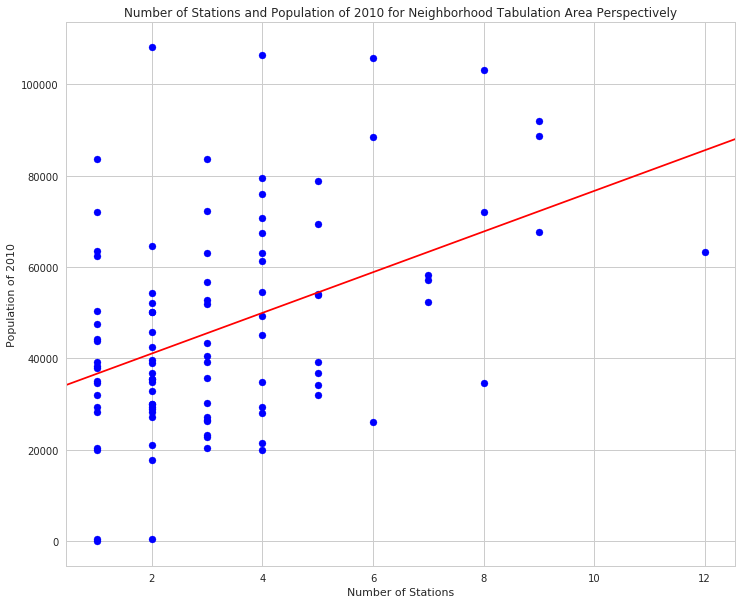

In [206]:
figure, ax = plt.subplots(figsize=(12, 10))
ax.scatter(x2, y2, c='b')

abline_plot(model_results=mod2, ax=ax, color='red')

x2 = StationshpSJoinDataAna3WOMN['Number of Stations']
y2 = StationshpSJoinDataAna3WOMN['Population_y']
pylab.xlabel('Number of Stations')
pylab.ylabel('Population of 2010')
pylab.title('Number of Stations and Population of 2010 for Neighborhood Tabulation Area Perspectively')
# plt.scatter(x2,y2) 
plt.show()

# Caption:
    This is a scatter plot for Number of Stations and Population of 2010 for Neighborhood Tabulation Area Perspectively with an OLS model result line fitted.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


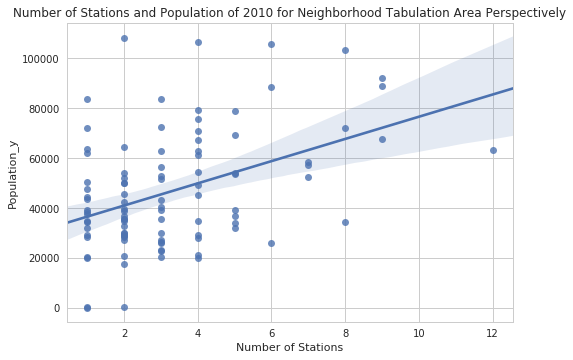

In [215]:
pl.ylabel("Number of Stations")
pl.xlabel("Population of 2010")
pl.title('Number of Stations and Population of 2010 for Neighborhood Tabulation Area Perspectively')
sns.regplot(x=x2, y=y2, data=StationshpSJoinDataAna3WOMN)

# Caption:
    https://seaborn.pydata.org/generated/seaborn.regplot.html
    This plot includes data, its linear regression model fit, and an error area.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


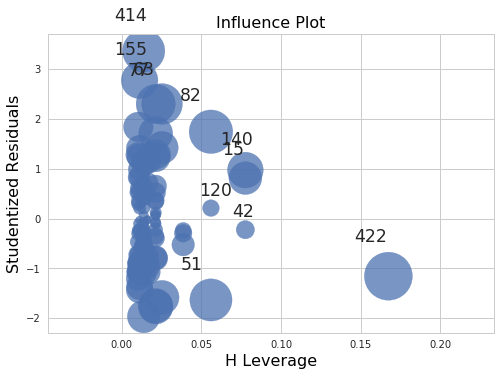

In [263]:
sm.graphics.influence_plot(mod2, alpha  = 0.05, criterion="cooks");

plt.show()

    This is a plot of influence in regression. It plots studentized resids vs. leverage.

In [205]:
mod2 = smf.ols(formula='y2 ~ x2', data = StationshpSJoinDataAna3WOMN).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     21.28
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           1.24e-05
Time:                        19:12:00   Log-Likelihood:                -1102.6
No. Observations:                  97   AIC:                             2209.
Df Residuals:                      95   BIC:                             2214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.216e+04   3845.481      8.362      0.0

# Caption: 
    After filtering out Manhattan the result is much better as the R-Squared value increased to 0.183. 
    The general trend (coefficient) is positive as well. The more population in an NTA, the more subway stations there are. 

In [225]:
StationshpSJoinDataAna3 = StationshpSJoinDataAna3.sort_values(by='Number of Stations', ascending=False)

In [226]:
StationshpSJoinDataAna3.head(10)

,ntacode,Number of Stations,line_y,name,objectid,boro_code,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
283,MN17,22,1-2,50th St,3.0,1.0,110,2000,25807,2010,28630,2823,0.000948
322,MN24,17,4-6-6 Express,Canal St,2.0,1.0,164,2000,36757,2010,42742,5985,0.001707
339,MN25,14,A-C,Fulton St,360.0,1.0,108,2000,20088,2010,39699,19611,0.002089
265,MN13,13,4-6-6 Express,23rd St,92.0,1.0,179,2000,55839,2010,70150,14311,0.001894
422,QN31,12,E-M-R,36th St,10.0,4.0,146,2000,61947,2010,63271,1324,0.000618
312,MN23,10,4-6-6 Express,Astor Pl,1.0,1.0,178,2000,68483,2010,66880,-1603,0.002675
140,BK82,9,J-Z,Van Siclen Ave,12.0,3.0,154,2000,83275,2010,91958,8683,0.000786
15,BK28,9,D,Bay Pky,314.0,3.0,82,2000,84640,2010,88727,4087,0.001901
42,BK37,9,2-3-4,Bergen St,4.0,3.0,144,2000,67263,2010,67649,386,0.001591
120,BK78,8,J,Halsey St,75.0,3.0,42,2000,64617,2010,72101,7484,0.001795


# Caption:
    MN32, BX40, MN22, MN14, and MN12 NTAs, which are the '86th st,' '182nd-183rd Streets,' '1st Ave,' '66th St- Lincoln Centerm,' and '86th Street' neighborhoods respectively have the highest population density.
    The Upper East Side has one of the highest population density in New York City. The three stations of the Second Avenue Subway commenced on January 1st, 2017, now deemed quite necessary.
    * 125/195 NTAs have subway access (where the subway stations are located).
    * The number could be larger since many NTAs are nearby.

In [211]:
x3 = StationshpSJoinDataAna3['Number of Stations']
y3 = StationshpSJoinDataAna3['PopDensity']
mod3 = smf.ols(formula='y3 ~ x3', data = StationshpSJoinDataAna3).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7385
Date:                Wed, 12 Dec 2018   Prob (F-statistic):              0.392
Time:                        19:36:18   Log-Likelihood:                 685.28
No. Observations:                 125   AIC:                            -1367.
Df Residuals:                     123   BIC:                            -1361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0020      0.000     14.400      0.0

# Caption:
    This is a linear regression model to find the relationship between the population density of an NTA and the number of stations of an NTA. However, this model cannot find the relationship well, nor it is statistically significant.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


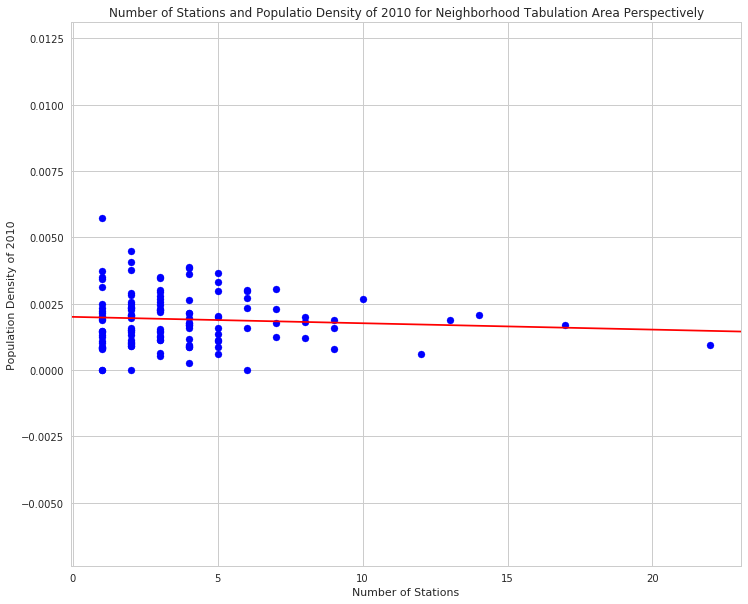

In [212]:
figure, ax = plt.subplots(figsize=(12, 10))
ax.scatter(x3, y3, c='b')

abline_plot(model_results=mod3, ax=ax, color='red')

pylab.xlabel('Number of Stations')
pylab.ylabel('Population Density of 2010')
pylab.title('Number of Stations and Populatio Density of 2010 for Neighborhood Tabulation Area Perspectively')
# plt.scatter(x2,y2) 
plt.show()

# Caption:
    This is a scatter plot for Number of Stations and Population Density of 2010 for Neighborhood Tabulation Area Perspectively with an OLS model result line fitted.

In [227]:
PopNTAMerge2010.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,PopDensity
311,1.0,Manhattan,061,MN32,Yorkville,1.360206e+07,17998.720847,(POLYGON ((-73.93804640603439 40.7808295442755...,Manhattan,2010,61,MN32,Yorkville,77942,0.005730
361,2.0,Bronx,005,BX40,Fordham South,6.308875e+06,15880.351973,POLYGON ((-73.89138023380343 40.86170058776047...,Bronx,2010,5,BX40,Fordham South,28262,0.004480
353,1.0,Manhattan,061,MN22,East Village,1.089432e+07,13555.239450,POLYGON ((-73.98255629231735 40.73135013455449...,Manhattan,2010,61,MN22,East Village,44136,0.004051
219,1.0,Manhattan,061,MN14,Lincoln Square,1.580559e+07,19869.908247,"POLYGON ((-73.97500111964057 40.7775277799167,...",Manhattan,2010,61,MN14,Lincoln Square,61489,0.003890
363,1.0,Manhattan,061,MN12,Upper West Side,3.437994e+07,29160.206287,POLYGON ((-73.96003018437119 40.79803810739433...,Manhattan,2010,61,MN12,Upper West Side,132378,0.003850


In [228]:
PopNTAMerge2010 = PopNTAMerge2010.sort_values(by='PopDensity', ascending=False)

In [246]:
PopNTAMerge2010.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,PopDensity
311,1.0,Manhattan,061,MN32,Yorkville,1.360206e+07,17998.720847,(POLYGON ((-73.93804640603439 40.7808295442755...,Manhattan,2010,61,MN32,Yorkville,77942,0.005730
361,2.0,Bronx,005,BX40,Fordham South,6.308875e+06,15880.351973,POLYGON ((-73.89138023380343 40.86170058776047...,Bronx,2010,5,BX40,Fordham South,28262,0.004480
353,1.0,Manhattan,061,MN22,East Village,1.089432e+07,13555.239450,POLYGON ((-73.98255629231735 40.73135013455449...,Manhattan,2010,61,MN22,East Village,44136,0.004051
219,1.0,Manhattan,061,MN14,Lincoln Square,1.580559e+07,19869.908247,"POLYGON ((-73.97500111964057 40.7775277799167,...",Manhattan,2010,61,MN14,Lincoln Square,61489,0.003890
363,1.0,Manhattan,061,MN12,Upper West Side,3.437994e+07,29160.206287,POLYGON ((-73.96003018437119 40.79803810739433...,Manhattan,2010,61,MN12,Upper West Side,132378,0.003850


In [247]:
StationshpSJoinDataAna3 = StationshpSJoinDataAna3.sort_values(by='PopDensity', ascending=False)
StationshpSJoinDataAna3.head()

,ntacode,Number of Stations,line_y,name,objectid,boro_code,index_right,Year_x,Population_x,Year_y,Population_y,PopulationChange,PopDensity
361,MN32,1,Q,86th St,642.0,1.0,155,2000,76768,2010,77942,1174,0.005730
212,BX40,2,B-D,182nd-183rd Sts,20.0,2.0,180,2000,26880,2010,28262,1382,0.004480
310,MN22,2,L,1st Ave,146.0,1.0,176,2000,41746,2010,44136,2390,0.004051
278,MN14,4,1-2,66th St - Lincoln Ctr,88.0,1.0,109,2000,55239,2010,61489,6250,0.003890
261,MN12,4,1-2,86th St,86.0,1.0,181,2000,136954,2010,132378,-4576,0.003850


MN50 - Stuyvesant Town-Cooper Village
BX46 - Parkchester
QN25 - Corona	
Do not have subway stations within the precinct in the top 30 Population Density list. 

However, the Stuyvesant Town-Cooper Village is partially served by the Canarsie Line - L Train and Parkchester is served by the 6 Train. The QN25, Corona in Queens does not have a subway station within its boundary nor nearby its boundaries. People living in the precinct need to travel relatively an extensive amount of distance for the subway service. There are supplementary bus services including Q38 and Q58 provide relatively convenient alternative transit options nontheless. 

In [186]:
# line_y data here does not work since it only shows one of stations for each station

In [189]:
# Try different schemes to previous maps
# check the nta and number of stations
# cb2015[(cb2015['hour'] > 18)].hour.hist()

In [190]:
# .plot(column='',scheme='',legend=True)